## _ARAS Database Quick Spectra Visualizer_
<img src="logo.gif" width="150" height="150" align="left"/>

[The database](http://www.astrosurf.com/aras/Aras_DataBase/DataBase.htm)

## _Packages and functions_

_Some imports_
This code mostly comes from ivandga github, all creadits belongs to him: https://github.com/ivandga/ArasSpectraNotebooks

In [42]:
import astropy.constants as const
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.io.fits as aif
from astropy.time import Time
import astropy.units as u
import astropy.utils.data as aua


import matplotlib.pyplot as pl
import numpy as np
import plotly.graph_objects as go

_This method downloads the spectrum data, it takes the .fit file URL as parameter._

In [20]:
def download_spectrum(link):
    try:
        hdul = aif.open(aua.download_file(link))
        hdr = hdul[0].header
        spectrum = hdul[0].data
    except:
        raise Exception("Broken file/link? {}".format(link))
        # For the record, we have:
        # CRVAL1 / Coordinate at reference pixel                  
        # CDELT1 / Coordinate increment
        # CUNIT1 / Wavelength unit, usually 'Angstrom'
        # BITPIX / Number of bits per data pixel (warn, sometimes put)
        # NAXIS  / Number of data axes, usually 1
        # NAXIS1 / Length of data axis 1, ie, number of bins
    wavelengths = hdr["CDELT1"] * np.arange(hdr["NAXIS1"]) + hdr["CRVAL1"]
    data = {"w": wavelengths, "f": spectrum, "date": hdr["DATE-OBS"], "hdr": hdr}
    return data

## Fits format in BeSS database
For the record, here is the documentation for the FITS format to be used in BeSS database (in french), please also record a few guidelines:

* Telluric bands should not be removed in the spectra, they may be useful for further analysis
* Spectra should not be corrected for heliocentric speed, this can be done later on

Here is the documentation:

In [21]:
from IPython.display import IFrame, display
filepath = "Spec_spectres_BeSS_fr.pdf"
IFrame(filepath, width=1000, height=400)

_Some other helpful methods_

**calculate_velocity**: returns the velocity array (in km/s) with respect to a specific wavlength _wl_

**linelabel**: simple text output with a specific wavelength _wl_

**plot_line**: plots the normalised flux (normalised with respect to the maximum flux of the dataset) from a dataset (specified with the index _i_ with the respect to the data structure) against the velocity array, centered on a specific wavelength _wl_; _dobs_ and _labwl_ specificy if the label of the plotted curve will show the data of the observation and/or the wavelength; _alpha_ (0,1) specifies the transparency of the curve; _factor_ rescales the curve.

In [22]:
def calculate_velocity(wave, wavelength):
    return 1e-3 * const.c * (wave - wavelength) / wavelength


def linelabel(wl):
    return "{:.1f} $\AA$".format(wl)


def plot_line(i, wl, dobs=False, labwl=False, alpha=1, factor=1):
    vel = calculate_velocity(data[i]["w"], wl)
    if dobs:
        label_for_line = "#{} - {}".format(i, data[i]["do"])
    if labwl:
        label_for_line = "#{} - {}".format(i, linelabel(wl))
    if labwl and dobs:
        label_for_line = "#{} - {} - {}".format(i, linelabel(wl), data[i]["do"])
    flux = data[i]["f"] / max(data[i]["f"])
    pl.plot(vel, flux * factor, label=label_for_line, alpha=alpha)

### _Define Aras fit URL and download the data_

In [23]:
link_spectrum = "http://www.astrosurf.com/aras/Aras_DataBase/Symbiotics/FitFiles/asdb_agdra_20190706_181.fit"
data = download_spectrum(link_spectrum)
print(data)

{'w': array([3710.75966176, 3712.05116176, 3713.34266176, ..., 7292.08916176,
       7293.38066176, 7294.67216176]), 'f': array([0.15858218, 0.14295365, 0.15982904, ..., 1.0333956 , 1.0317265 ,
       0.917077  ], dtype=float32), 'date': '2019-07-06T04:21:14', 'hdr': SIMPLE  =                    T / File does conform to FITS standard             
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    1 / Number of data axes                            
NAXIS1  =                 2776 / Length of data axis 1                          
CRVAL1  =      3710.7596617635 / Coordinate at reference pixel                  
CDELT1  =               1.2915 / Coordinate increment                           
VERSION = 'ISIS V5.9.6'        / Software version                               
OBJNAME = 'AG Dra  '           / Current name of the object                     
DATE-OBS= '2019-07-06T04:21:14' / Date of observation start                     
EXP

## _Define wavelength interval_

In [24]:
xmin = data["w"].min()  # or a number
xmax = data["w"].max()  # or a number

_Plotting the stuff with matplotlib_

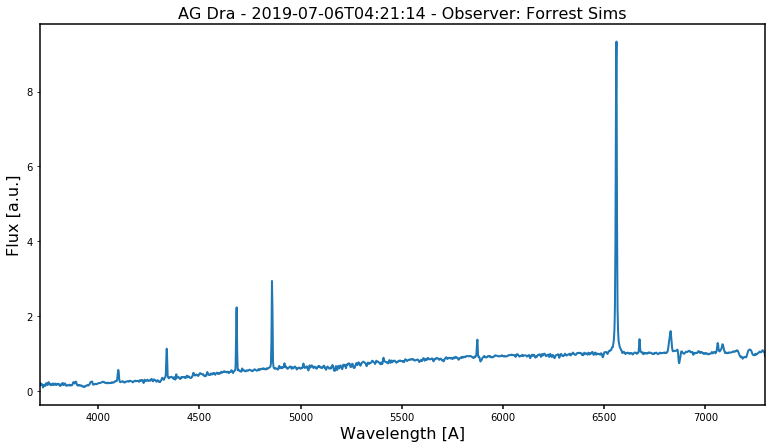

In [25]:
pl.figure(0, figsize=(13, 7))
pl.xlabel("Wavelength [A]")
pl.ylabel("Flux [a.u.]")
pl.title(
    "{} - {} - Observer: {}".format(
        data["hdr"]["OBJNAME"], data["date"], data["hdr"]["OBSERVER"]
    )
)
pl.xlim(xmin, xmax)
pl.plot(data["w"], data["f"])

_Plotting with plotly, an interactive graphic library_

In [29]:
#fig = go.Figure(data=go.Scatter(x=data["w"], y=data["f"]))
#fig.update_layout(
#    title="{} - {} - Observer: {}".format(
#        data["hdr"]["OBJNAME"], data["date"], data["hdr"]["OBSERVER"]
#    )
#)
#fig.update_xaxes(title_text="Wavelength [A]")
#fig.update_yaxes(title_text="Flux [a.u.]")
#fig.show()

# Analyzing further the spectra

## Correcting for radial velocity
See here for the documentation: https://docs.astropy.org/en/stable/coordinates/velocities.html#radial-velocity-corrections



In [53]:
#To account for the radial velocity, we will need the following informations from the fits header
# DATE-OBS / Date of observation start format is like '2019-07-06T04:21:14' 
# GEO_LONG / Obs. geographic longitude, format is like 111.802777
# GEO_LAT / Obs. geographic latitude, format is like 33.3672222
# GEO_ELEV / Obs. geographic elevation, in m ? format is like 380
# OBJNAME / Current name of the object format is like 'AG Dra  '


location = EarthLocation.from_geodetic(lat=data['hdr']["GEO_LAT"]*u.deg,
                                       lon=data['hdr']["GEO_LONG"]*u.deg,
                                       height=data['hdr']["GEO_ELEV"]*u.m)
#sc = SkyCoord(ra=4.88375*u.deg, dec=35.0436389*u.deg)
sc = SkyCoord.from_name(data['hdr']["OBJNAME"])
ot = Time(data['hdr']["DATE-OBS"])

#barycentric radial velocity correction
barycorr = sc.radial_velocity_correction(obstime=ot, location=location)
print("barycentric radial velocity correction is {}".format(barycorr.to(u.km/u.s)))

#heliocentric radial velocity correction
heliocorr = sc.radial_velocity_correction('heliocentric', obstime=ot, location=location)
print("heliocentric radial velocity correction is {}".format(heliocorr.to(u.km/u.s)))


barycentric radial velocity correction is -5.076870270337843 km / s
heliocentric radial velocity correction is -5.084586319452631 km / s


<SkyCoord (ICRS): (ra, dec) in deg
    (240.4208857, 66.80281422)>